# Approfondimento dataviz



In [1]:
#importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer.pitch import Pitch, VerticalPitch
from mplsoccer import PyPizza, Radar
from highlight_text import fig_text
from adjustText import adjust_text
from database.read_db import *


                full_name
0      Fabio Quagliarella
1         Andrea Consigli
2           Miguel Veloso
3            Rui Patrício
4          Daniel Ciofani
..                    ...
310          Yayah Kallon
311  Federico Baschirotto
312        Jacopo Fazzini
313      Felix Afena-Gyan
314         Joan González

[315 rows x 1 columns]


# Loghi squadre

In questo esempio vedremo come visualizzare i loghi delle squadre in un grafico in Python. Questi concetti si applicano a qualsiasi tipo di immagine che si può voler inserire nel grafico, ma l'utilizzo dei loghi è sicuramente l'applicazione più ovvia nell'ambito calcistico.

Utilizziamo come esempio uno scatterplot di dati di squadra per la Serie A 2022/23. I file immagine dei loghi sono stati forniti separatamente, e i nomi dei file corrispondono a quelli presenti nel dataset.

Per poter visualizzare immagini da file PNG nel nostro grafico andiamo a definire una funzione per importarli:

In [2]:
def getImage(path, zoom = 0.25, zorder = 1, alpha = 1):
    return OffsetImage(plt.imread(path), zoom=zoom, alpha = alpha, zorder = zorder)

Andiamo quindi a leggere i nostri dati e a indicare dove trovare il file immagine per i loghi:

In [3]:
df =read_db('ds.team_stats').set_index('team_id')
df['logo_path'] = [f'team_logos/{x}.png' for x in df.logo]

A questo punto possiamo costruire il nostro scatterplot usando xG e xGA, andando prima a inserire uno scatterplot "vuoto" per fissare lo spazio del grafico e tracciando le linee mediane. Per inserire i loghi, facciamo un ciclo sul nostro dataframe andando a chiamare la funzione `getImage` definita in precedenza, all'interno della funzione `AnnotationBbox` di Matplotlib, piazzando l'immagine nelle coordinate desiderate.

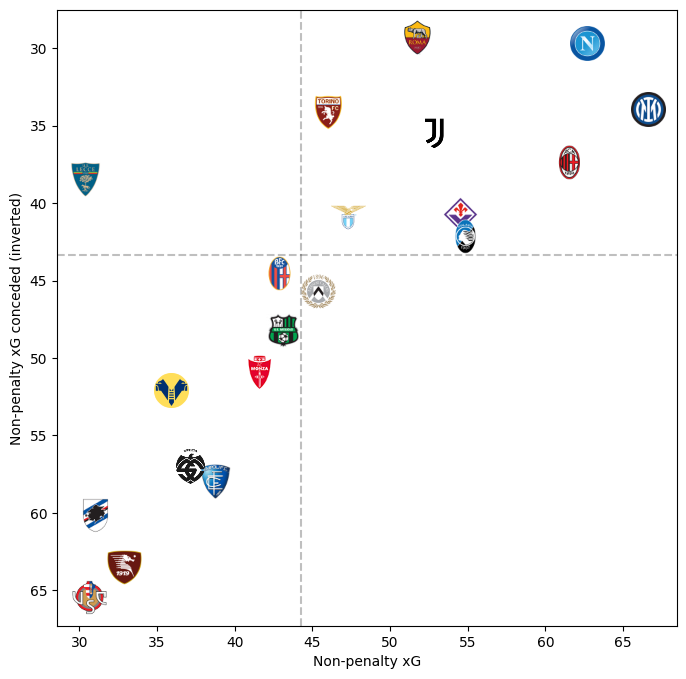

In [4]:
f, ax = plt.subplots(figsize = (8,8))

#scatterplot con marker di dimensione nulla per fissare il grafico
ax.scatter(df.npxG, df.npxGA, s = 0)

#linee mediane
ax.axvline(df.npxG.median(), color = 'black', ls = '--', alpha = 0.25)
ax.axhline(df.npxGA.median(), color = 'black', ls = '--', alpha = 0.25)

#inserimento imamgini loghi
for i,r in df.iterrows():
    ab = AnnotationBbox(getImage(r.logo_path), xy = (r.npxG, r.npxGA), xycoords = 'data', frameon=False, annotation_clip=False)
    ax.add_artist(ab)

#invertire l'asse y
ax.invert_yaxis()
ax.set_xlabel('Non-penalty xG')
ax.set_ylabel('Non-penalty xG conceded (inverted)')
plt.show()

# Composizione di figure multiple

Vediamo come combinare diversi grafici in un'unica figura in modo efficiente.

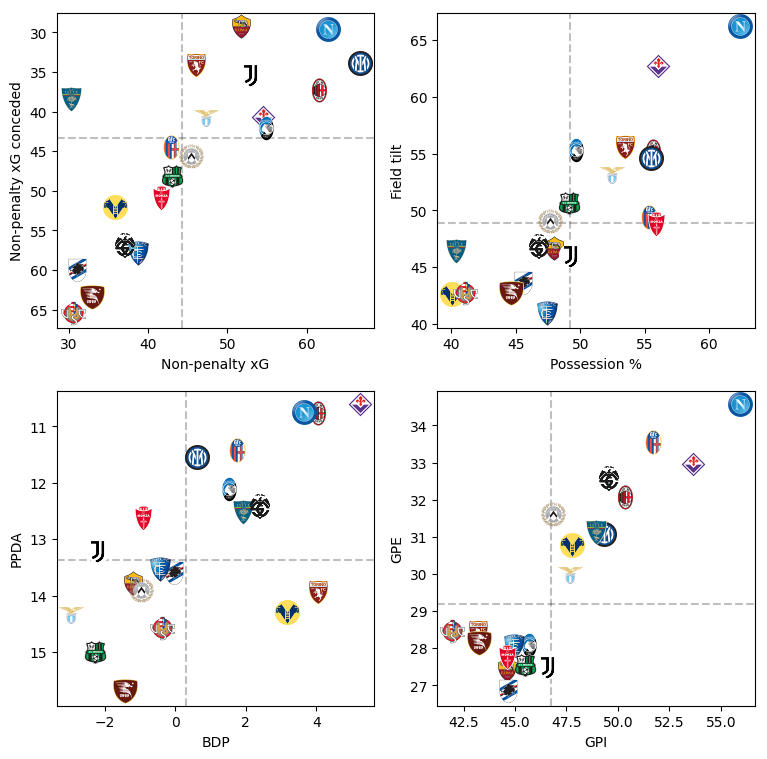

In [5]:
f, ax = plt.subplots(2,2, figsize = (9,9))

#impostazione variabili
xvars = ['npxG', 'possession_percentage', 'bdp', 'gpi']
xlabels = ['Non-penalty xG', 'Possession %', 'BDP', 'GPI']
invert_x = [False, False, False, False]

yvars = ['npxGA', 'field_tilt', 'ppda', 'gpe']
ylabels = ['Non-penalty xG conceded', 'Field tilt', 'PPDA', 'GPE']
invert_y = [True, False, True, False]

#make scatterplots with for cycle with flatten
for i, (xv, yv, ix, iy, xl, yl) in enumerate(zip(xvars, yvars, invert_x, invert_y, xlabels, ylabels)):
    ax.flatten()[i].scatter(df[xv], df[yv], s = 0)
    ax.flatten()[i].set_xlabel(xl)
    ax.flatten()[i].set_ylabel(yl)

    #add median lines
    ax.flatten()[i].axvline(df[xv].median(), color = 'black', ls = '--', alpha = 0.25)
    ax.flatten()[i].axhline(df[yv].median(), color = 'black', ls = '--', alpha = 0.25)

    #insert logos
    for j,r in df.iterrows():
        ab = AnnotationBbox(getImage(r.logo_path, zoom = 0.175), xy = (r[xv], r[yv]), xycoords = 'data', frameon=False, annotation_clip=False)
        ax.flatten()[i].add_artist(ab)
    if ix:
        ax.flatten()[i].invert_xaxis()
    if iy:
        ax.flatten()[i].invert_yaxis()

plt.show()

È possibile gestire i subplots in maniera più flessibile e diretta usando la funzione `subplot_mosaic`. Supponiamo di voler mostrare due scatterplot con a lato un grafico a barre.

In [6]:
df['npxGD'] = df.npxG - df.npxGA
df = df.sort_values('npxGD', ascending = False).reset_index()

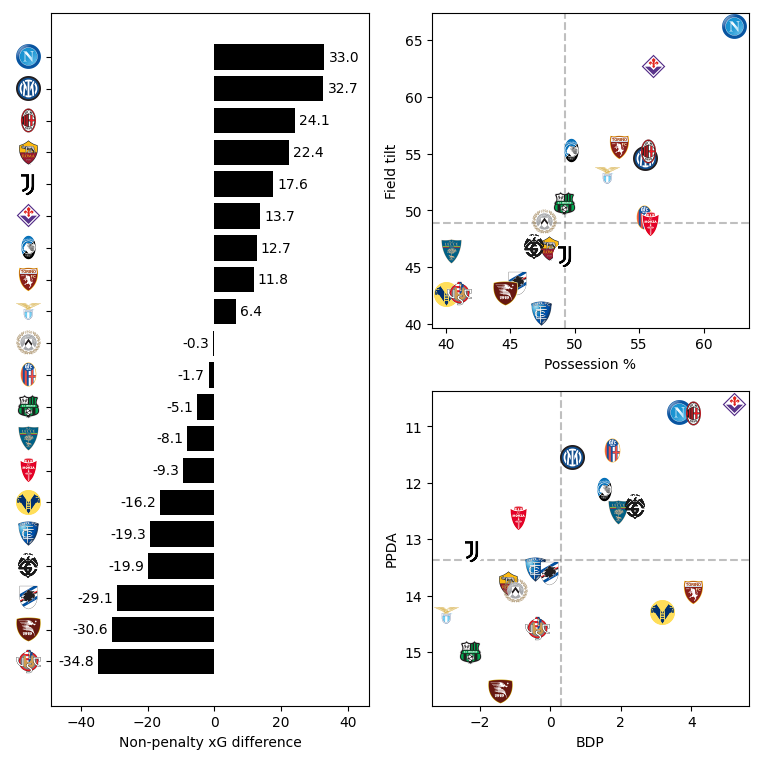

In [7]:
#creazione del dizionario di assi
axd = plt.figure(figsize = (9,9)).subplot_mosaic(
                    """
                    AB
                    AC
                    """
                )

#bar chart
bars = axd['A'].barh(df.index, df.npxGD, color = 'black', zorder = 10)
axd['A'].bar_label(bars, fmt = '%.1f', padding = 3)
for i,r in df.iterrows():
    ab = AnnotationBbox(getImage(r.logo_path, zoom = 0.175), xy = (-0.075,i), xycoords = ('axes fraction', 'data'), frameon=False, annotation_clip=False)
    axd['A'].add_artist(ab)

axd['A'].set_yticks(df.index, labels = [])
axd['A'].invert_yaxis()
axd['A'].set_xlim(df.npxGD.min()*1.4, df.npxGD.max()*1.4)

axd['A'].set_xlabel('Non-penalty xG difference')

#scatter 1: possession vs field tilt
axd['B'].scatter(df.possession_percentage, df.field_tilt, s = 0)
axd['B'].axvline(df.possession_percentage.median(), color = 'black', ls = '--', alpha = 0.25)
axd['B'].axhline(df.field_tilt.median(), color = 'black', ls = '--', alpha = 0.25)
axd['B'].set_xlabel('Possession %')
axd['B'].set_ylabel('Field tilt')
for i,r in df.iterrows():
    ab = AnnotationBbox(getImage(r.logo_path, zoom = 0.175), xy = (r.possession_percentage, r.field_tilt), xycoords = 'data', frameon=False, annotation_clip=False)
    axd['B'].add_artist(ab)

#scatter 2: BDP vs PPDA
axd['C'].scatter(df.bdp, df.ppda, s = 0)
axd['C'].axvline(df.bdp.median(), color = 'black', ls = '--', alpha = 0.25)
axd['C'].axhline(df.ppda.median(), color = 'black', ls = '--', alpha = 0.25)
axd['C'].set_xlabel('BDP')
axd['C'].set_ylabel('PPDA')
for i,r in df.iterrows():
    ab = AnnotationBbox(getImage(r.logo_path, zoom = 0.175), xy = (r.bdp, r.ppda), xycoords = 'data', frameon=False, annotation_clip=False)
    axd['C'].add_artist(ab)
axd['C'].invert_yaxis()
plt.show()

# Personalizzazione del grafico

In molti casi può essere opportuno modificare l'aspetto dei nostri grafici per creare uno stile riconoscibile e uniforme, andando a cambiare colori e impostazioni di default. Ci sono diversi modi di ottenere questo risultato, sia direttamente nel codice che stabilendo un formato fisso da importare separatamente.

Vediamo un esempio tornando allo scatterplot di npxG vs. npxGA visto prima. Se volessimo usare uno sfondo scuro, l'opzione più veloce è quella di usare uno degli stili predefiniti di Matplotlib (lista completa qui: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).

In [8]:
plt.style.use('dark_background')

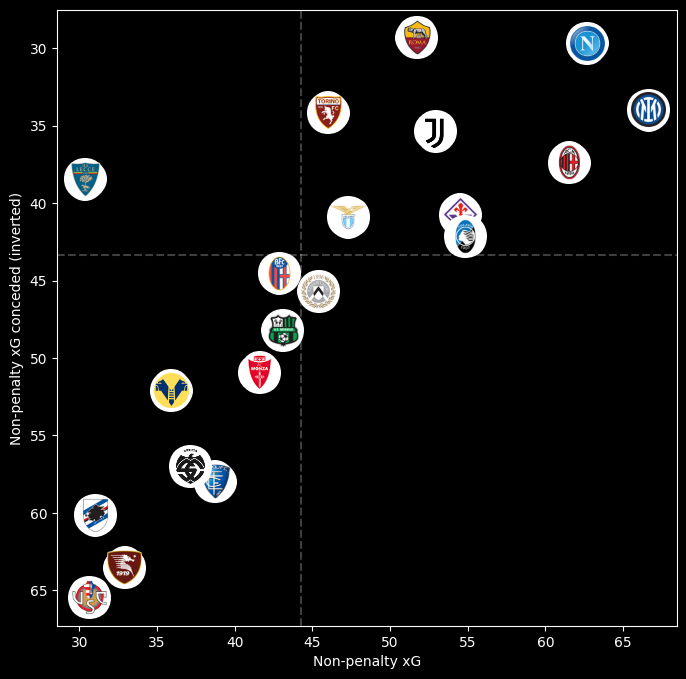

In [9]:
f, ax = plt.subplots(figsize = (8,8))

#scatterplot con marker di dimensione nulla per fissare il grafico
ax.scatter(df.npxG, df.npxGA, s = 0)

#linee mediane
ax.axvline(df.npxG.median(), ls = '--', alpha = 0.25)
ax.axhline(df.npxGA.median(), ls = '--', alpha = 0.25)

#inserimento imamgini loghi
for i,r in df.iterrows():
    #aggiunta di un bordo bianco per rendere alcuni loghi più visibili
    ab = AnnotationBbox(getImage(r.logo_path), xy = (r.npxG, r.npxGA), xycoords = 'data', bboxprops=dict(boxstyle='circle', ec = 'none'), annotation_clip=False)
    ax.add_artist(ab)

#invertire l'asse y
ax.invert_yaxis()
ax.set_xlabel('Non-penalty xG')
ax.set_ylabel('Non-penalty xG conceded (inverted)')
plt.show()

Volendo avere più controllo sui dettagli dello stile del grafico, la pratica migliore è quella di creare un cosiddetto stylesheet personalizzato, in cui si possono impostare i valori di default desiderati per tantissime opzioni.

In [12]:
plt.style.use('test.mplstyle')

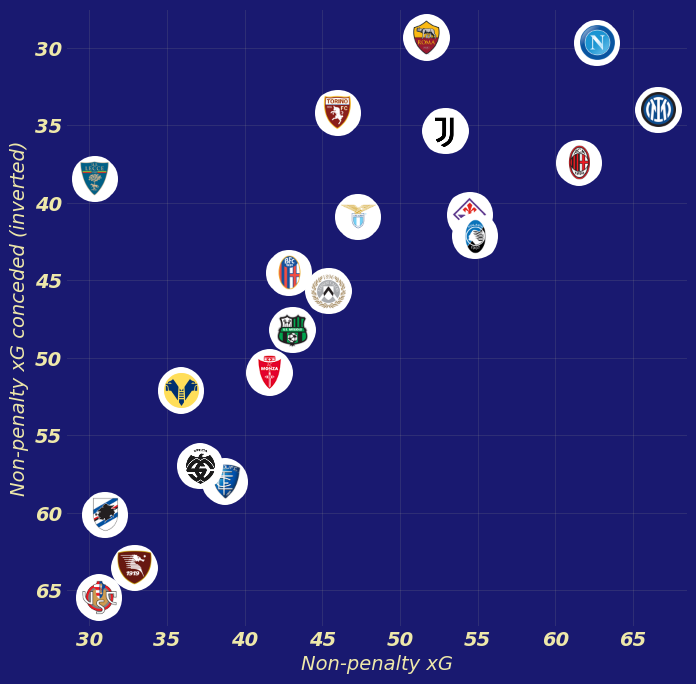

In [13]:
f, ax = plt.subplots(figsize = (8,8))

#scatterplot con marker di dimensione nulla per fissare il grafico
ax.scatter(df.npxG, df.npxGA, s = 0)

#inserimento imamgini loghi
for i,r in df.iterrows():
    #aggiunta di un bordo bianco per rendere alcuni loghi più visibili
    ab = AnnotationBbox(getImage(r.logo_path), xy = (r.npxG, r.npxGA), xycoords = 'data', bboxprops=dict(boxstyle='circle', ec = 'none'), annotation_clip=False)
    ax.add_artist(ab)

#invertire l'asse y
ax.invert_yaxis()
ax.set_xlabel('Non-penalty xG')
ax.set_ylabel('Non-penalty xG conceded (inverted)')
plt.show()

Si può ripristinare lo stile di default semplicemente chiamandolo tramite la stessa funzione `plt.style.use`.

In [14]:
#revert to default matplotlib style
plt.style.use('default')

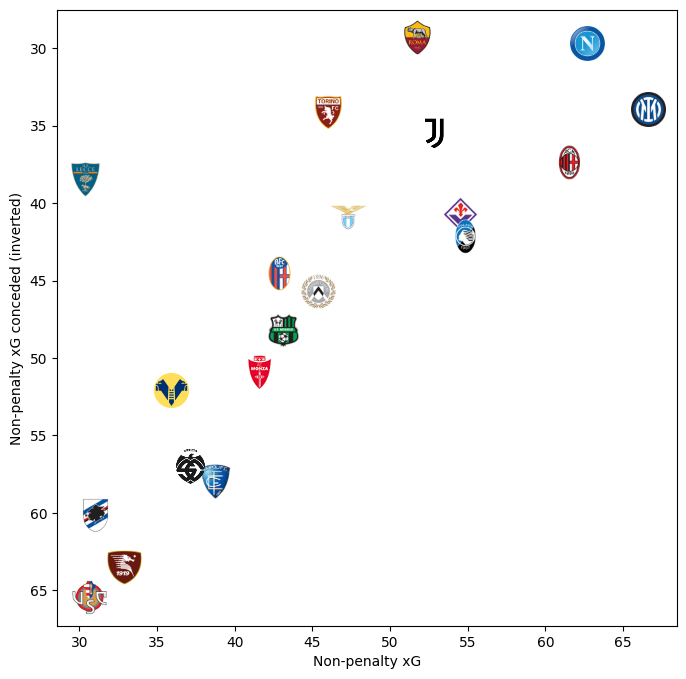

In [15]:
f, ax = plt.subplots(figsize = (8,8))

#scatterplot con marker di dimensione nulla per fissare il grafico
ax.scatter(df.npxG, df.npxGA, s = 0)

#inserimento imamgini loghi
for i,r in df.iterrows():
    #aggiunta di un bordo bianco per rendere alcuni loghi più visibili
    ab = AnnotationBbox(getImage(r.logo_path), xy = (r.npxG, r.npxGA), xycoords = 'data', frameon=False, annotation_clip=False)
    ax.add_artist(ab)

#invertire l'asse y
ax.invert_yaxis()
ax.set_xlabel('Non-penalty xG')
ax.set_ylabel('Non-penalty xG conceded (inverted)')
plt.show()